In [17]:
import pygame as pg
import sys
import random
import numpy as np

In [18]:
def obstacle_render(obs_list,obst_list):
    if obs_list:
        for i in range (len(obs_list)):
            screen.blit(pipe,pipe.get_rect(topright=obs_list[i]))
            screen.blit(pipet,pipet.get_rect(topright=obst_list[i]))
            obst_list[i][0]=obst_list[i][0]-4
            obs_list[i][0]=obst_list[i][0]-4
        if obs_list[0][0]<100:
            del obs_list[0]
            del obst_list[0]
        return obs_list,obst_list
    else:
        return[],[]

In [19]:
def create_tile_encoding(state, num_tiles_x=50, num_tiles_y=57):
    # Define the ranges for x, y, and velocity
    x=state[0]
    y=state[1]
    min_x, max_x = 0, 620
    min_y, max_y = 0, 850
    
    # Calculate tile widths for each dimension
    tile_width_x = (max_x - min_x) / num_tiles_x
    tile_width_y = (max_y - min_y) / num_tiles_y
    
    # Calculate the tile indices for each dimension
    tile_index_x = int((x - min_x) // tile_width_x)
    tile_index_y = int((y - min_y) // tile_width_y)
    
    return [tile_index_x,tile_index_y]

In [20]:
# x = horizontal distance between birdcenter and the pipe right range={0,4,....,604}, 50 tiles
# y = vertical distance of birdcenter and bottom pipe top range=[-300,475], 50 tiles
# z = velocity of the bird range=[-47,21], 10 tiles 
# last one denotes action
Q_value=np.zeros((50,57,2))

In [21]:
eps=0.0001
td_error=0.8
Y=0.8

In [22]:
def get_next_state(cur,obs_list):
    nexts=[0,0]
    if obs_list[0][0]==100:
        nexts[0]=(obs_list[1][0]-100)/4
        if cur[2]==0:
            nexts[1]=int(obs_list[1][1]-s+(t+0.5)*(t+0.5)-(t+0.5)*a+301)
        if cur[2]==1:
            nexts[1]=int(obs_list[1][1]-(s+t*t-t*a + 0.5*0.5 -0.5*21)+301)
    else:
        nexts[0]=cur[0]-1
        if cur[2]==0:
            nexts[1]=int(obs_list[0][1]-s+(t+0.5)*(t+0.5)-(t+0.5)*a+301)
        if cur[2]==1:
            nexts[1]=int(obs_list[0][1]-(s+t*t-t*a + 0.5*0.5 -0.5*21)+301)
    for i in range(2):
        nexts[i]=int(nexts[i])
    return nexts

In [23]:

pg.init()
screen=pg.display.set_mode((1200,576))
pg.display.set_caption("Hello")
clock=pg.time.Clock()
font = pg.font.Font('freesansbold.ttf', 22)
sky=pg.image.load('game_dev/finalbg.jpg').convert()
pipe=pg.image.load('game_dev/pipe.png').convert_alpha()
pipe=pg.transform.scale(pipe,(100,500))
pipet=pg.transform.rotate(pipe,180)
pipet=pg.transform.flip(pipet,True,False)
pipet_rect=pipet.get_rect(topleft=(1200,-50))
pipe_rect=pipe.get_rect(topleft=(1200,300))
pipe_rect_copy=pipe.get_rect(topleft=(550,300))
pipet_rect_copy=pipet.get_rect(topleft=(550,-50))
bird=pg.image.load('game_dev/bird.png').convert_alpha()
bird=pg.transform.scale(bird,(70,50))
bird_rect=bird.get_rect(center=(100,100))
sbt=font.render("START",True,"red")
sbt_rect=sbt.get_rect(center=(600,288))
screen.blit(sbt,sbt_rect)

#defining timer for the obstacles to occur
for i in range(1000):
    bird_rect=bird.get_rect(center=(100,400))
    timer=pg.USEREVENT+1
    pg.time.set_timer(timer,2000)

    #bird=pg.transform.rotate(bird,-30)
    obs_list=[[500,400],[900,300],[1200,400]]
    obst_list=[[500,400-680],[900,300-680],[1200,400-680]]
    t=0
    a=0
    score="0"
    s=bird_rect.centery
    text = font.render(score, True, (77,208,225))
    text_rect = text.get_rect(center=(600,80))
    el=pg.draw.circle(screen,"blue",bird_rect.center,20)
    done=False
    cur_st=[0,0]
    cur_st[0]=(obs_list[0][0]-100)/4
    cur_st[1]=obs_list[0][1]-bird_rect.centery+301
    while not done:
        #draw everything and update
        for event in pg.event.get():
            if event.type==pg.QUIT:
                print(l)
                pg.quit()
                sys.exit()
            #if event.type==pg.KEYDOWN:
                #s=s+t*t-t*a
                #a=21
                #t=0.5
            if event.type==timer:
                x=4*random.randint(300,330)
                y=400+random.randint(-150,100)
                obs_list.append([x,y])
                obst_list.append([x,y-680])
        # defining thr rectangle postions
        el=pg.draw.circle(screen,"blue",bird_rect.center,20)
        
        #S
        
        screen.blit(sky,(-100,0))
        bird_rect.centery=s+t*t-t*a
        v=a-t*2
        screen.blit(bird,bird_rect)
        screen.blit(text,text_rect)

        obs_list,obst_list=obstacle_render(obs_list,obst_list)
        cur_st_en=create_tile_encoding(cur_st)
        #A
        if random.uniform(0,1)<eps:
            action=random.randint(0,1)
        else:
            action=np.argmax(Q_value[tuple(cur_st_en)])
        cur_st.append(action)
        cur_st_en.append(action)
        
        #S'
        next_state=get_next_state(cur_st,obs_list)
        next_state_en=create_tile_encoding(next_state)
        # in one time stamp x reduces by one and y by an amout specified by an equation of motion
        # so in order to find the subsequent states i would need to do a lookahead in the s using a hypothetical 
        # jump or no jump and then check the max of q values of both states and decide greedly....

        
        
        if cur_st[2]==0:
            ys=s+(t+0.5)*(t+0.5)-(t+0.5)*a
        else:
            ys=s+t*t-t*a + 0.5*0.5 -0.5*21
        el1=pg.draw.circle(screen,"blue",(104,ys),20)
        if  el1.colliderect(pipe.get_rect(topright=obs_list[0])) or el1.colliderect(pipet.get_rect(topright=obst_list[0])) or el1.bottom>=571 or el1.top<=5:
            reward=-400
            done=True
            Q_value[tuple(cur_st_en)]+=td_error*(reward)
        else:
            if random.uniform(0,1)<eps:
                action_next=random.randint(0,1)
            else:
                action_next=np.argmax(Q_value[tuple(next_state_en)])
            next_state.append(action_next)
            next_state_en.append(action_next)
            reward=0.5
            if next_state[0]==0:
                reward=5
            Q_value[tuple(cur_st_en)]+=td_error*(reward + Y*(Q_value[tuple(next_state_en)]-Q_value[tuple(cur_st_en)]))

        if action==1:
            s=s+t*t-t*a
            t=0
            a=21

        if obs_list and el.right==obs_list[0][0]+16:
            score=str(eval(score)+1)
            smax=max(0,eval(score))
            print(smax)

            text = font.render(score, True,(77,208,225))
        #if (obs_list and obst_list and (el.colliderect(pipe.get_rect(topleft=obs_list[0])) or el.colliderect(pipet.get_rect(topleft=obst_list[0])))) or bird_rect.bottom>=576 or bird_rect.top<=0:
            #pg.quit()
            #sys.exit()
        print(next_state[1])
        t=t+0.5
        pg.display.update()
        #clock.tick(60)
        cur_st=[next_state[0],next_state[1]]
    

301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
445
457
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
83
78
74
70
67
64
62
60
59
58
58
58
59
60
62
64
67
70
74
78
83
88
94
100
107
114
122
130
139
148
158
168
179
190
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
83
78
74
70
67
64
62
60
59
58
58
58
59
60
62
64
67
70
74
78
83
88
94
100
107
114
122
130
139
148
158
168
179
168
138
128
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
83
78
74
70
67
64
62
60
59
58
58
58
59
60
62
64
67
70
74
78
83
88
94
100
107
114
122
130
139
148
199
168
159
150
142
245
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
83
78
74
70
67
64
62
60
5

271
266
261
257
253
250
247
245
243
242
241
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
83
78
74
70
67
64
62
60
59
58
58
58
59
60
62
64
67
70
74
78
83
88
94
100
107
240
210
260
230
220
212
203
196
188
182
175
170
164
345
315
306
297
289
281
274
267
261
255
250
245
241
237
234
231
229
227
226
225
225
225
226
227
229
231
1
234
137
141
145
150
155
161
167
174
181
189
197
206
215
225
235
246
257
269
281
294
307
321
159
129
120
111
103
95
88
81
75
69
64
59
55
51
48
45
43
41
40
39
39
39
40
41
43
45
48
51
55
59
64
69
75
81
88
95
103
111
197
208
218
228
198
189
180
172
164
282
252
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
83
78
74
70
67
64
62
60
59
58
58
58
59
60
62
64
67
70
74
78
83
88
94
253
223
273
283
293
263
254
245
237
229
222
215
209
203
198
193
189
185
182
179
177
175
174
173
173
173
174
175
177
179
182
185
189
193

139
130
122
114
107
100
94
88
83
78
74
70
67
64
62
60
59
58
58
58
59
60
62
64
67
70
277
287
257
307
317
287
278
346
357
367
377
347
338
406
376
367
436
405
396
387
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
83
78
74
70
67
64
62
60
59
58
58
58
59
60
62
64
67
70
277
287
257
307
317
287
278
346
357
367
337
327
319
310
303
295
289
282
441
411
402
470
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
83
78
74
70
67
64
62
60
59
58
58
58
59
60
62
64
67
70
277
287
257
307
317
287
278
346
357
367
337
327
319
310
413
383
374
365
357
349
342
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
83
78
74
70
67
64
62
60
59
58
58
58
59
60
62
64
67
70
277
287
257
307
317
287
278
346
316
307
376
345
396
365
356
347
339
331
324
317
311
470
301
302
303
305
307
310


391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
83
78
74
70
67
280
250
240
232
223
326
296
287
278
270
262
380
390
401
411
421
391
441
451
462
472
442
492
502
512
523
492
483
474
561
571
581
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
83
78
74
70
67
280
290
260
310
320
290
340
351
320
311
380
350
340
332
323
426
396
446
456
467
436
487
497
467
457
449
440
433
425
419
412
407
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
83
78
74
70
67
280
290
260
310
320
290
281
272
264
367
377
347
397
407
417
428
397
448
458
468
478
489
499
469
519
529
499
549
519
569
539
530
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
83
78
74
70
67
280
290
260
310
320
331
341
351
361
372
382
352
402
412
422
392
442
453
463
473
483
494
463
514
483
534
544


385
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
259
228
219
288
298
268
259
250
242
234
227
220
214
208
378
388
399
409
379
369
361
352
345
337
331
324
483
453
444
512
482
532
502
493
484
570
581
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
259
228
219
288
258
248
240
231
224
216
210
203
198
192
188
183
180
176
389
359
350
341
333
325
318
311
305
299
294
289
285
281
487
457
448
439
525
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
259
228
279
248
239
230
222
214
207
200
194
188
183
178
174
170
167
164
162
160
159
158
158
158
159
160
162
164
167
170
174
178
183
364
374
344
394
364
414
384
375
366
452
422
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
259


373
382
391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
83
78
74
70
67
64
62
60
59
288
258
308
318
328
339
349
359
369
380
390
360
410
380
430
400
390
382
468
478
448
439
430
422
414
407
400
546
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
199
168
159
150
142
134
127
120
114
108
103
98
94
90
87
84
82
80
79
78
78
78
79
80
82
84
87
90
94
98
103
108
279
289
299
309
320
330
340
350
361
330
381
350
401
411
381
371
363
354
347
465
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
199
168
159
228
238
248
259
228
219
210
202
194
187
320
330
340
351
361
331
381
351
401
411
381
372
363
449
419
410
401
393
385
378
371
517
487
537
547
517
508
499
585
596
606
616
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
199
209
179
229
199
249
219
209
201
192
295
265
256
324
335
345
355
365
376
345
396
406
376
426
396
446
416
406
398
389
382
37

357
349
342
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
201
170
221
190
181
250
260
230
280
290
260
251
320
330
300
290
282
368
378
388
358
408
419
429
439
409
459
429
479
449
440
431
423
415
533
543
513
504
573
583
593
603
614
583
634
644
614
604
673
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
190
200
170
161
152
144
136
129
122
116
110
105
100
96
92
89
86
84
82
81
80
80
80
81
82
84
86
89
92
96
100
105
110
116
122
129
136
254
224
215
283
253
244
235
227
219
212
205
351
321
371
341
332
323
315
307
300
293
287
281
276
271
267
263
260
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
201
170
161
152
144
136
129
262
232
282
252
302
272
262
254
245
348
318
309
300
292
284
277
409
420
389
380
449
419
409
478
488
499
509
479
529
539
509
500
568
579
589
599
609
620
589
640
650
620
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
1

272
282
293
262
313
323
333
343
354
364
374
384
395
405
375
425
395
445
455
465
435
485
496
506
516
526
537
506
557
526
577
587
597
607
618
628
638
648
618
668
638
301
302
303
305
307
310
313
317
321
326
331
337
343
350
262
272
282
293
262
313
323
333
343
354
364
334
384
394
404
374
424
394
444
455
465
435
485
495
505
516
526
536
546
516
566
536
586
597
607
617
587
637
647
658
668
678
301
302
303
305
307
310
313
317
321
326
331
281
250
241
310
320
330
341
351
361
371
382
392
362
412
422
392
442
452
463
432
423
414
406
398
517
486
537
506
557
526
577
587
597
607
618
587
578
647
617
607
599
590
301
302
303
305
307
310
313
317
321
326
331
281
250
301
311
321
331
342
352
322
372
382
392
403
372
423
392
443
453
463
473
484
494
504
514
525
494
545
514
565
534
585
554
545
536
623
592
583
574
661
630
681
301
302
303
305
307
310
313
317
321
326
331
281
250
301
311
321
331
342
352
322
372
382
392
403
372
423
392
443
453
463
433
483
493
504
514
524
534
545
514
565
534
585
554
605
615
585
575
644


331
342
352
322
372
342
392
362
352
344
335
438
448
459
469
439
489
459
509
519
529
499
549
560
529
520
511
503
495
488
621
631
641
652
662
632
682
311
321
331
342
352
322
372
342
392
362
352
344
335
438
448
459
469
439
489
459
509
519
529
540
509
560
529
520
511
503
495
488
621
631
641
652
621
672
682
311
321
331
342
352
322
372
342
392
362
352
344
335
438
448
459
469
439
489
459
509
479
469
461
547
517
507
499
490
593
603
573
564
555
547
539
532
525
671
682
311
321
331
342
352
322
372
342
392
362
352
344
335
438
448
459
469
439
489
459
509
479
469
461
547
517
507
499
490
593
603
573
564
555
547
539
532
525
671
641
311
321
331
342
352
322
372
342
392
362
352
344
335
438
448
459
469
439
489
459
509
479
469
538
548
559
528
579
548
539
530
617
627
637
647
658
627
678
311
321
331
342
352
322
372
342
392
362
352
344
335
438
448
459
469
439
489
459
509
479
469
461
547
517
507
499
490
593
603
573
564
633
643
613
663
633
623
311
321
331
342
352
322
372
342
392
362
352
344
335
438
448
459
469


343
337
332
327
323
319
316
313
311
309
308
307
307
307
308
309
311
313
316
319
323
327
332
337
343
349
356
363
371
379
466
476
446
436
428
514
484
474
466
301
302
303
305
307
310
313
317
295
265
255
247
333
303
293
285
276
269
261
394
404
415
425
435
445
456
425
416
407
399
391
384
377
371
365
360
355
351
347
344
341
560
529
520
511
503
495
488
481
475
469
464
459
455
451
448
445
443
441
440
439
439
439
440
441
443
445
448
451
455
301
302
303
305
307
310
313
317
295
265
315
325
335
305
296
287
279
271
264
257
251
410
420
390
440
450
420
411
402
394
386
379
372
366
360
355
350
346
342
548
518
509
500
492
484
477
470
464
458
453
448
444
642
612
603
672
641
301
302
303
305
307
310
313
317
321
326
331
337
343
269
238
289
258
249
318
328
338
308
299
290
376
387
356
407
376
367
358
350
453
423
413
405
396
389
381
375
368
527
497
488
479
471
463
456
449
443
437
607
577
627
637
648
617
608
599
301
302
303
305
307
310
313
317
295
305
315
326
336
306
296
365
335
326
394
364
355
346
338
330
323


389
384
378
374
369
366
362
360
357
356
354
354
353
354
354
356
357
360
362
366
369
374
378
384
389
548
518
509
500
586
556
547
538
530
632
643
653
623
613
605
311
321
331
301
351
362
331
382
392
362
352
421
431
442
411
402
393
385
377
370
363
357
351
346
341
337
536
506
496
488
479
472
464
458
451
446
616
586
576
568
559
552
544
677
301
302
303
305
307
310
313
317
295
265
255
247
238
231
223
217
210
205
199
195
190
389
359
350
341
427
397
388
379
371
473
443
493
463
454
445
531
501
492
483
475
467
460
593
562
553
544
631
600
651
620
671
640
311
281
331
301
291
283
274
267
259
253
246
241
235
231
226
223
429
399
389
381
372
365
357
351
344
339
509
479
469
461
452
445
563
533
523
515
506
499
491
485
478
473
467
463
458
455
451
449
446
445
443
443
442
443
443
445
446
449
667
677
311
281
271
263
349
319
369
339
329
321
407
377
427
437
407
398
389
381
373
366
359
353
511
522
532
542
512
503
571
541
532
523
515
507
625
595
586
577
569
561
554
311
281
271
263
254
247
365
335
325
394
364
355


337
331
325
495
505
516
485
476
467
459
451
444
437
431
425
420
415
411
407
404
401
399
397
396
395
395
395
396
397
399
401
404
407
411
415
420
425
431
437
444
451
459
467
476
485
495
526
536
546
557
526
577
311
281
271
263
254
247
239
233
379
389
359
409
379
429
439
409
459
470
480
490
500
511
480
531
541
551
521
512
503
495
487
480
473
467
461
456
451
447
443
440
437
435
433
432
431
431
431
432
433
435
437
440
443
447
451
456
461
467
473
480
487
495
597
567
617
587
637
648
658
628
311
281
271
263
254
247
239
233
226
221
215
211
206
203
199
197
194
193
191
191
190
191
191
193
194
197
199
203
206
211
215
221
226
233
239
372
342
333
324
316
308
426
396
387
378
370
362
355
348
342
336
331
326
322
318
315
312
310
308
307
306
306
306
307
308
310
312
315
318
322
311
281
271
263
254
247
239
233
226
221
215
211
206
203
199
197
194
193
191
191
190
191
191
193
194
197
199
203
206
211
215
221
226
233
239
247
254
357
327
318
309
301
293
286
279
273
267
262
257
253
249
246
243
241
239
238
237
237


410
410
410
411
412
414
416
419
632
601
592
661
631
621
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
259
228
219
210
202
194
187
180
174
333
303
293
285
276
269
261
255
248
407
377
427
397
447
417
408
399
485
495
506
516
486
476
468
459
562
532
582
311
281
271
263
254
247
239
233
379
349
339
331
322
315
307
301
294
289
283
279
274
271
267
480
450
500
470
461
452
444
436
429
422
416
410
405
400
590
560
551
542
534
636
647
616
667
636
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
433
179
148
139
130
122
114
107
100
94
88
83
78
74
70
67
64
62
60
59
58
58
58
59
60
62
64
67
70
74
78
83
88
94
100
107
240
210
200
192
278
288
258
249
240
232
224
217
210
204
198
193
373
343
393
404
373
424
434
404
394
463
301
311
321
291
281
273
264
257
249
243
236
395
365
415
385
376
367
359
351
344
337
331
325
320
315
311
307
304
301
299
297
296
295
295
295
296
297
299
301
304
307
311

294
296
298
301
304
308
312
317
322
328
334
341
348
356
364
373
382
392
402
413
424
436
448
461
474
488
327
337
347
317
367
337
387
357
348
339
425
395
386
377
369
301
302
303
305
307
310
313
317
321
326
331
281
250
241
232
224
216
209
202
196
190
185
180
176
375
345
335
327
318
311
303
297
290
285
279
275
270
267
263
261
258
257
255
255
254
255
255
257
258
261
263
267
270
275
279
285
290
297
303
311
318
421
391
382
450
461
471
441
431
423
301
302
303
305
307
310
313
317
321
326
331
281
250
301
270
261
252
244
236
229
222
216
210
205
200
196
395
365
355
347
338
331
323
317
310
305
299
295
290
287
283
281
278
277
275
275
274
275
275
277
278
281
283
287
493
463
453
445
436
429
421
415
408
403
397
393
388
385
381
379
301
302
303
305
307
310
313
317
321
326
331
281
291
261
251
243
234
227
219
213
206
201
195
191
186
183
179
177
395
365
355
347
338
331
323
317
310
305
299
295
290
287
283
496
466
457
448
440
432
425
418
412
406
401
396
392
388
385
382
380
378
377
376
606
576
626
636
606
597


317
321
326
331
281
250
241
232
224
216
209
202
196
190
185
180
176
375
385
355
346
337
329
321
439
409
459
429
420
411
497
467
458
449
441
433
426
419
413
407
402
397
393
389
386
598
609
619
589
579
648
618
609
677
301
302
303
305
307
310
313
317
321
326
331
281
250
241
232
224
216
209
202
196
190
185
180
176
172
169
166
164
162
161
160
160
160
161
162
164
166
169
172
176
180
185
190
196
202
209
216
224
232
241
250
260
270
281
292
304
316
329
342
356
195
165
155
147
233
203
193
185
176
301
302
303
305
307
310
313
317
321
326
331
281
250
241
232
224
216
335
345
355
365
335
385
355
405
375
366
435
404
395
386
378
370
363
356
350
344
339
334
330
326
533
502
493
484
571
540
531
522
514
506
499
492
639
649
619
609
601
301
302
303
305
307
310
313
317
321
326
331
281
250
241
232
224
216
209
202
196
190
185
180
176
172
169
166
164
162
161
160
160
160
161
162
164
166
169
172
176
180
185
190
196
202
209
216
224
232
241
250
260
270
281
292
304
316
329
342
356
195
165
155
147
233
243
213
204
195


211
206
203
199
197
194
193
191
191
190
191
191
193
194
197
199
203
206
211
215
221
226
385
355
346
337
329
431
442
411
402
393
385
377
370
363
357
351
346
341
337
333
330
327
325
323
322
321
321
321
322
323
325
327
330
333
337
341
346
311
281
271
263
254
247
239
233
226
221
391
361
411
421
391
382
373
365
357
350
343
337
331
326
506
517
486
477
468
460
452
445
438
432
426
421
416
412
408
405
402
400
398
397
396
396
396
397
398
400
402
405
408
412
416
421
602
612
582
573
641
611
661
631
622
301
302
303
305
307
310
313
317
295
265
255
247
238
231
223
217
210
205
199
195
190
187
183
181
178
177
175
175
174
175
175
177
178
181
399
369
359
351
342
335
327
321
314
309
479
489
499
469
460
451
443
546
556
526
576
546
596
566
556
548
634
604
654
624
614
606
301
302
303
305
307
310
313
317
295
265
255
247
238
231
223
217
210
205
199
195
190
187
183
181
178
177
175
175
174
175
175
177
178
181
183
187
190
195
385
355
345
337
328
321
313
307
300
295
289
285
280
277
273
271
268
267
265
265
264
265


356
350
344
339
334
330
326
323
320
318
316
315
314
314
314
315
316
318
320
323
326
330
334
339
344
350
356
363
370
378
386
395
404
454
464
475
301
302
303
305
307
310
313
317
295
265
255
247
238
231
349
319
309
301
292
285
277
271
264
259
253
249
244
241
237
235
232
231
229
229
228
229
229
231
232
235
237
241
244
249
253
259
264
271
277
285
292
301
309
319
328
339
349
361
327
297
287
279
270
263
255
249
242
237
407
417
427
397
388
379
371
301
302
303
305
307
310
313
317
295
265
255
247
238
341
351
321
312
303
295
287
280
413
423
433
443
454
423
414
405
397
389
382
375
369
363
358
353
349
345
342
339
337
335
334
333
333
333
334
335
337
339
342
345
552
562
572
542
533
524
516
618
588
579
648
658
628
678
301
302
303
305
307
310
313
317
295
265
255
247
333
303
353
323
313
382
392
362
412
423
392
383
452
422
412
404
395
388
380
374
367
526
536
547
516
567
536
527
518
605
574
565
556
548
540
533
526
520
514
509
301
302
303
305
307
310
313
317
295
265
255
247
238
231
349
319
309
301
292
395


270
263
256
250
409
378
369
360
352
344
337
330
324
318
313
308
304
300
297
294
292
290
289
288
288
288
289
290
292
294
297
300
304
308
313
318
324
330
337
344
352
360
369
378
388
419
389
439
409
459
469
479
449
311
281
271
263
254
247
239
233
226
221
391
401
411
381
372
363
355
347
340
333
327
321
316
311
307
303
300
297
515
526
495
486
477
469
461
454
447
441
435
430
611
581
571
563
554
547
665
675
301
302
303
305
307
310
313
317
295
265
255
247
238
231
349
319
309
301
292
285
277
271
264
259
253
434
444
455
424
415
406
398
390
383
376
370
364
359
540
510
500
569
539
530
521
513
505
498
491
485
479
474
469
465
461
458
455
453
451
450
449
449
449
679
301
302
303
305
307
310
313
317
295
305
275
266
257
249
241
234
366
336
327
318
310
302
295
288
282
276
446
457
426
417
408
400
392
385
378
372
366
361
356
352
348
345
342
340
338
337
336
336
336
337
338
340
342
345
348
352
356
361
366
372
378
385
392
511
521
531
541
511
561
531
301
302
303
305
307
310
313
317
295
305
275
266
334
345
314


189
191
194
197
201
205
210
215
221
227
373
343
334
402
372
363
354
440
410
401
392
301
302
303
305
307
310
313
317
295
265
255
247
238
231
223
217
210
205
199
195
190
187
183
181
178
177
175
175
174
175
175
177
178
181
399
409
379
370
361
353
345
338
331
325
319
314
309
305
301
298
295
293
291
290
289
289
289
290
291
293
295
298
301
305
309
314
319
325
331
338
345
353
361
370
379
429
439
409
400
391
301
302
303
305
307
310
313
317
295
265
255
247
238
231
223
217
210
205
199
195
190
187
183
181
178
177
175
175
174
175
175
177
178
181
183
187
190
195
385
355
345
337
328
321
313
307
300
295
289
285
280
277
273
271
268
267
265
265
264
265
265
267
268
271
273
277
280
285
289
295
300
307
313
321
328
337
423
433
403
394
385
301
302
303
305
307
310
313
317
295
265
255
247
238
231
223
217
210
205
199
195
190
389
359
350
341
333
325
318
311
305
299
294
289
285
281
278
275
273
495
465
456
447
439
431
549
519
510
501
493
485
478
471
465
459
454
449
445
441
438
435
433
431
430
659
628
619
301
302


512
507
311
321
331
301
351
321
371
341
332
323
315
307
300
293
439
450
419
410
401
393
385
378
371
365
359
354
349
345
341
548
517
508
499
491
483
476
469
463
457
452
447
443
439
436
433
431
429
428
427
427
427
428
429
431
433
652
621
612
603
301
311
321
291
281
273
264
257
249
243
236
395
365
356
347
339
331
324
317
311
305
300
295
485
495
506
475
526
495
486
477
564
533
524
515
507
499
492
485
479
473
468
463
459
455
452
449
447
445
444
443
443
443
444
445
447
449
452
455
459
463
654
623
614
605
311
321
291
282
273
265
257
250
243
237
395
365
415
385
376
367
359
351
344
337
331
325
320
315
311
307
304
301
299
297
296
295
295
295
296
297
299
301
304
307
311
315
320
325
331
337
344
351
359
367
376
385
395
405
416
427
439
451
464
477
491
330
299
290
281
273
265
258
251
245
239
234
229
225
221
218
215
213
211
210
209
209
209
210
211
213
215
218
431
441
411
402
470
311
321
291
282
273
265
257
250
382
352
343
334
326
318
311
304
298
292
287
282
278
274
271
268
266
264
263
262
262
262
263


371
384
397
411
425
440
221
190
181
172
164
156
301
302
303
305
307
310
313
317
295
265
255
247
238
231
223
217
210
205
199
195
190
187
183
181
178
177
175
175
174
175
175
177
178
181
183
187
190
195
199
205
210
217
223
231
238
247
255
265
274
285
295
307
318
331
343
357
370
385
399
415
430
301
302
303
305
307
310
313
317
295
265
255
247
238
231
223
217
210
205
199
195
190
187
183
181
178
177
175
175
174
175
175
177
178
181
183
187
190
195
199
205
210
217
223
231
238
247
255
265
274
285
295
307
318
331
343
357
370
385
399
415
430
301
302
303
305
307
310
313
317
295
265
315
325
335
305
296
287
279
271
264
257
251
245
240
235
231
227
224
221
439
409
400
391
383
486
496
466
456
525
495
486
554
524
515
584
553
544
613
583
573
565
556
549
541
535
528
301
302
303
305
307
310
313
317
295
265
315
325
335
305
296
287
279
271
264
257
251
245
240
235
231
227
224
221
219
217
216
215
215
215
216
217
219
221
224
227
231
235
240
245
251
257
264
271
279
287
296
305
315
325
336
347
359
371
384
397
263


397
393
390
387
385
383
382
381
381
381
382
383
385
387
390
603
572
563
554
546
538
531
524
518
512
507
311
281
271
263
254
247
239
233
226
221
215
211
206
203
199
197
194
193
191
191
190
191
191
193
194
197
199
203
206
211
215
221
226
233
239
247
254
263
271
281
290
301
311
323
334
347
359
373
386
401
415
196
166
157
148
140
132
125
118
112
106
101
96
92
88
85
82
80
78
311
281
271
263
254
247
239
233
226
221
215
211
206
203
199
197
194
193
191
191
190
191
191
193
194
197
199
203
206
211
215
221
226
233
239
247
254
263
271
281
290
301
311
323
334
347
359
373
386
401
415
196
166
157
148
140
132
125
118
112
106
101
281
251
242
233
225
217
210
203
197
191
186
181
177
173
170
167
165
163
162
161
161
161
162
163
165
167
385
396
365
416
385
376
367
359
351
1
470
311
281
271
263
254
247
239
233
226
221
391
401
411
422
391
442
411
462
472
482
452
502
512
482
473
542
552
522
512
504
495
488
480
474
467
462
456
452
447
444
440
438
435
434
432
432
431
432
432
434
435
438
440
444
447
452
456
462
4

355
354
353
353
353
354
355
357
359
362
365
369
373
564
533
524
301
302
303
305
307
310
313
317
321
326
331
281
250
241
232
224
216
209
202
196
190
185
180
176
172
169
166
164
162
161
160
160
160
161
162
164
166
169
172
176
180
185
190
196
202
209
216
224
232
241
250
260
270
281
292
304
316
329
342
356
370
385
166
136
186
156
206
176
166
301
302
303
305
307
310
313
317
321
326
331
281
250
241
232
224
216
209
202
196
190
185
180
176
172
169
166
164
162
161
160
160
160
161
162
164
166
169
172
176
180
185
190
196
202
209
216
224
232
241
250
260
270
281
292
304
316
329
342
356
370
385
166
176
186
156
206
176
226
301
302
303
305
307
310
313
317
321
326
331
281
250
241
232
224
216
209
202
196
190
185
180
176
172
169
166
164
162
161
160
160
160
161
162
164
166
169
172
176
180
185
190
196
202
209
216
224
232
241
250
260
291
261
311
281
271
263
254
247
239
233
226
221
215
211
206
203
199
197
194
193
191
191
190
191
191
193
194
197
199
203
206
211
215
221
226
233
379
349
339
408
418
429
439
449


1
388
279
271
263
256
249
243
237
232
227
223
219
216
213
211
209
208
207
207
207
208
209
211
213
216
219
223
227
232
237
243
249
256
263
271
373
343
334
325
317
309
302
295
289
283
278
273
269
265
262
259
257
255
254
253
253
253
254
255
257
259
262
265
269
468
437
488
498
508
518
529
539
549
301
302
303
305
307
310
313
317
321
326
331
281
250
241
232
224
216
209
202
196
190
185
180
176
172
169
166
164
162
161
160
160
160
161
162
164
166
169
172
176
180
185
190
196
202
209
216
224
232
241
250
260
270
281
292
304
316
329
342
356
370
385
166
136
186
156
206
176
166
301
302
303
305
307
310
313
317
321
326
331
281
250
241
232
224
216
209
202
196
190
185
180
176
172
169
166
164
162
161
160
160
160
161
162
164
166
169
172
176
180
185
190
196
202
209
216
224
232
241
250
260
270
281
292
304
316
329
342
356
370
385
166
136
186
156
206
176
166
301
302
303
305
307
310
313
317
321
326
331
281
250
241
232
224
216
209
202
196
190
185
180
176
172
169
166
164
162
161
160
160
160
161
162
164
166
169
17

338
388
358
349
340
426
396
387
1
456
325
311
281
271
263
254
247
239
233
226
221
215
211
206
405
375
366
357
443
453
423
414
405
397
389
382
375
369
363
358
353
349
345
342
339
337
335
334
333
333
333
334
335
337
339
342
345
349
353
358
363
369
375
521
491
482
473
465
457
450
443
589
559
550
541
533
525
518
511
505
499
311
281
271
263
254
247
239
233
226
221
215
211
206
203
199
197
194
193
191
191
190
191
191
193
194
197
199
203
206
211
215
221
226
233
239
247
254
263
271
281
290
301
311
323
334
347
359
373
386
401
415
196
166
157
148
140
132
125
118
112
106
101
96
92
88
85
82
80
78
311
281
271
263
254
247
239
233
226
221
215
211
206
203
199
197
194
193
191
191
190
191
191
193
194
197
199
203
206
211
215
221
226
233
239
247
254
263
271
281
290
301
311
323
334
347
359
373
386
401
415
196
166
157
148
140
132
125
118
112
106
101
96
92
88
294
264
314
284
275
266
352
322
372
382
393
362
353
344
336
328
447
416
407
311
281
271
263
254
247
239
233
226
221
215
211
206
203
199
197
194
193
191


575
678
311
321
291
282
273
265
257
250
382
352
343
334
326
318
436
447
457
467
437
487
457
507
477
468
459
545
555
525
516
507
499
491
484
477
471
465
460
455
645
656
666
636
311
321
291
282
273
265
257
250
243
237
395
365
356
347
433
444
454
424
414
406
397
390
382
376
369
364
358
354
349
346
342
340
337
336
334
334
333
334
334
336
337
340
342
346
349
354
358
364
369
376
382
515
485
535
505
496
487
573
543
534
525
517
509
502
495
489
483
478
473
469
311
321
291
282
273
265
257
250
382
352
402
372
363
354
440
451
420
411
402
394
386
379
372
366
360
355
350
346
342
339
336
334
332
331
330
330
330
331
332
334
336
339
342
346
545
515
565
535
585
555
545
537
528
521
639
609
599
591
582
301
311
321
291
281
273
264
257
249
382
352
402
372
422
392
383
374
366
468
438
488
458
449
440
526
496
487
478
470
462
455
448
442
436
431
426
422
418
415
628
638
648
618
668
678
301
311
321
291
281
273
264
257
249
243
236
395
365
415
385
376
367
453
423
414
405
397
389
382
375
369
363
358
353
349
345
342


369
375
508
478
528
311
281
271
263
254
247
239
233
226
221
215
211
206
203
199
197
194
193
191
191
190
191
191
193
194
197
199
203
206
211
215
221
226
233
239
247
254
357
327
318
309
301
293
286
279
273
267
262
257
253
249
246
243
241
239
238
237
237
237
238
239
241
243
246
249
253
257
447
457
427
311
281
271
263
254
247
239
233
226
221
215
211
206
203
199
197
194
193
191
191
190
191
191
193
194
197
199
203
206
211
215
221
226
233
239
247
254
263
271
281
290
301
311
323
334
347
359
373
386
401
415
431
446
165
135
126
117
203
173
164
155
147
139
132
125
119
113
108
103
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
221
190
181
172
164
156
149
142
136
130
125
120
116
112
109
106
104
102
101
100
100
100
101
102
104
106
109
112
116
120
311
280
271
262
254
246
239
232
226
220
215
210
206
202
199
196
194
192
191
190
190
190
191
192
194
196
199
202
206
210
215
220
226
232
239
246
254
262
271
280
290
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365


220
212
204
197
190
184
178
173
168
164
160
157
154
152
150
149
148
148
148
149
150
152
154
157
160
164
168
173
178
184
190
197
204
212
220
229
238
248
258
269
280
292
304
223
192
183
174
166
158
277
287
257
247
301
302
303
305
307
310
313
317
321
326
331
337
343
269
238
229
220
212
204
197
190
184
178
173
168
164
160
157
154
152
150
149
148
148
148
149
150
152
154
157
160
164
168
173
178
184
190
197
204
212
220
229
298
268
258
250
241
234
352
362
372
383
393
363
353
345
336
329
321
315
308
303
301
302
303
305
307
310
313
317
321
326
331
337
343
269
238
229
220
212
204
197
190
184
178
173
168
164
160
157
154
152
150
149
148
148
148
149
150
152
154
157
160
164
168
173
178
184
190
197
204
212
220
229
298
268
258
250
241
234
352
362
372
383
393
363
353
345
336
329
321
315
308
303
301
302
303
305
307
310
313
317
321
326
331
337
343
269
238
229
220
212
204
197
190
184
178
173
168
164
160
157
154
152
150
149
148
148
148
149
150
152
154
157
160
164
168
173
178
184
190
197
204
212
220
229
298


184
190
197
204
212
220
229
238
248
258
269
280
292
304
223
192
183
174
166
158
151
144
291
301
301
302
303
305
307
310
313
317
321
326
331
337
343
269
238
229
220
212
204
197
190
184
178
173
168
164
160
157
154
152
150
149
148
148
148
149
150
152
154
157
160
164
168
173
178
184
190
197
204
212
220
229
238
248
258
269
280
292
304
223
192
183
174
166
158
277
246
237
228
301
302
303
305
307
310
313
317
321
326
331
337
343
269
238
229
220
212
204
197
190
184
178
173
168
164
160
157
154
152
150
149
148
148
148
149
150
152
154
157
160
164
168
173
178
184
190
197
204
212
220
229
238
248
258
269
280
292
304
223
192
183
174
166
158
151
144
138
132
301
302
303
305
307
310
313
317
321
326
331
337
343
269
238
229
220
212
204
197
190
184
178
173
168
164
160
157
154
152
150
149
148
148
148
149
150
152
154
157
160
164
168
173
178
184
190
197
204
212
220
229
238
248
258
269
280
292
304
223
192
243
212
203
194
186
289
259
249
301
302
303
305
307
310
313
317
321
326
331
337
343
269
238
229
220
212
204


344
336
329
322
316
301
302
303
305
307
310
313
317
321
326
331
337
343
269
238
229
220
212
204
197
190
184
178
173
168
164
160
157
154
152
150
149
148
148
148
149
150
152
154
157
160
164
168
173
178
184
190
197
330
300
290
282
273
266
258
252
245
240
234
230
225
222
428
398
388
380
371
364
356
350
301
302
303
305
307
310
313
317
321
326
331
337
343
269
238
229
220
212
204
197
190
184
178
173
168
164
160
157
154
152
150
149
148
148
148
149
150
152
154
157
160
164
168
173
178
184
190
197
204
212
315
285
275
267
258
251
243
237
230
225
219
400
370
361
352
344
336
329
322
468
301
302
303
305
307
310
313
317
321
326
331
337
343
269
238
229
220
212
204
197
190
184
178
173
168
164
160
157
154
152
150
149
148
148
148
149
150
152
375
345
335
327
318
311
303
297
290
285
279
275
270
267
263
261
258
257
255
255
254
255
255
257
258
261
263
267
270
275
279
285
290
297
303
311
318
327
335
345
354
365
375
345
335
327
318
311
303
297
290
285
279
275
270
267
301
302
303
305
307
310
313
317
321
326
331


524
535
545
555
565
576
545
536
605
615
585
576
567
559
661
631
681
311
281
331
301
291
360
330
321
312
304
296
414
384
375
366
358
350
343
336
330
324
319
314
310
306
303
300
298
296
295
294
294
294
295
296
298
300
303
306
310
314
319
324
330
488
458
449
440
432
424
417
410
404
398
393
388
384
380
377
374
372
370
369
368
368
368
369
370
372
374
311
281
331
301
291
360
330
321
312
304
296
414
384
375
366
358
350
343
336
330
324
319
314
310
306
303
300
298
296
295
294
294
294
295
296
298
300
303
306
310
314
319
324
330
488
458
449
440
432
424
417
410
404
398
393
388
384
380
377
374
372
370
369
368
368
368
369
370
372
374
311
281
331
301
291
360
330
321
312
304
296
414
384
375
366
358
350
343
336
330
324
319
314
310
508
478
469
460
452
444
437
430
424
418
413
408
404
400
397
394
392
390
389
388
388
388
389
390
392
394
397
400
404
408
413
418
424
430
437
570
580
590
560
551
542
534
526
519
512
506
311
281
331
301
291
283
369
339
329
321
312
305
297
291
437
407
397
389
380
373
365
359
352


323
317
310
469
479
449
440
431
423
415
408
401
395
389
384
379
375
371
368
365
363
361
360
359
359
359
360
361
363
365
368
371
375
574
543
534
301
302
303
305
307
310
313
317
321
326
331
281
250
241
232
224
216
209
202
196
190
185
180
176
172
169
166
164
162
161
160
160
160
161
162
164
166
169
382
352
342
334
325
318
310
304
297
292
286
282
277
274
270
268
265
264
262
262
261
262
262
264
265
268
270
274
277
282
286
292
297
304
310
318
325
334
342
352
361
392
362
412
382
432
442
412
403
301
302
303
305
307
310
313
317
321
326
331
281
291
261
251
243
234
227
219
213
206
201
195
191
186
183
179
177
174
173
171
171
170
171
171
173
174
177
179
183
186
191
195
201
206
213
219
227
234
243
251
261
270
281
291
303
314
327
339
353
366
381
395
411
426
301
302
303
305
307
310
313
317
321
326
331
281
291
261
251
243
234
227
219
213
206
201
195
191
186
183
179
177
174
173
171
171
170
171
171
173
174
177
179
183
186
191
195
201
206
213
219
227
345
315
305
297
288
281
273
267
260
255
249
245
240
237


In [24]:
eps/=10

0


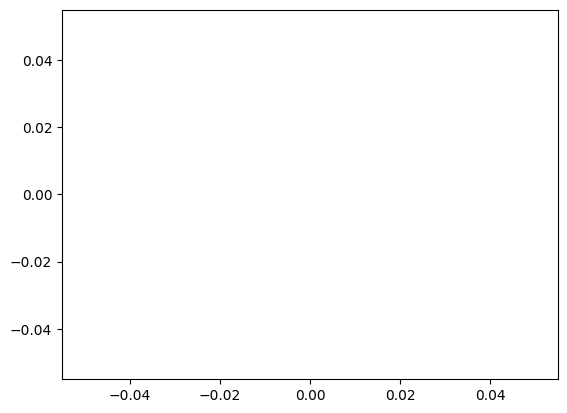

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


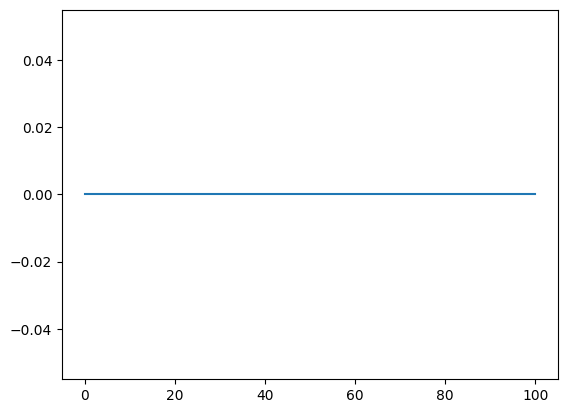

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


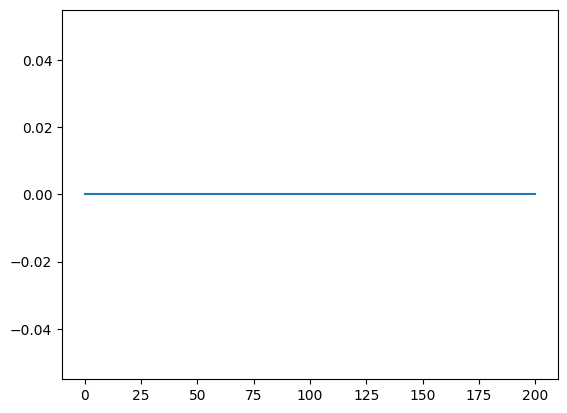

201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300


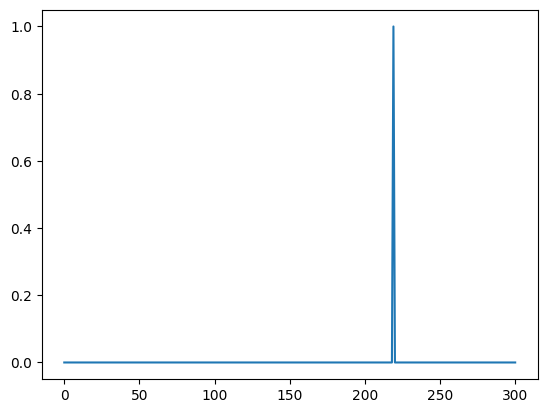

301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400


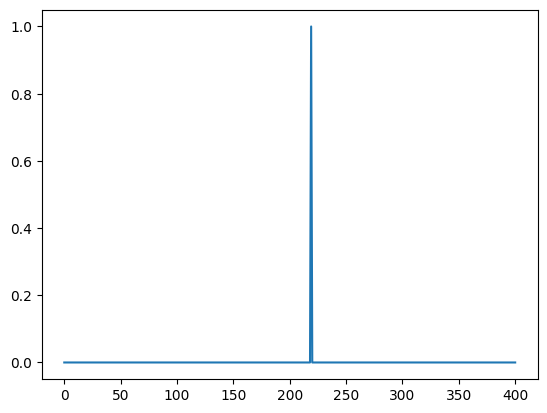

401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500


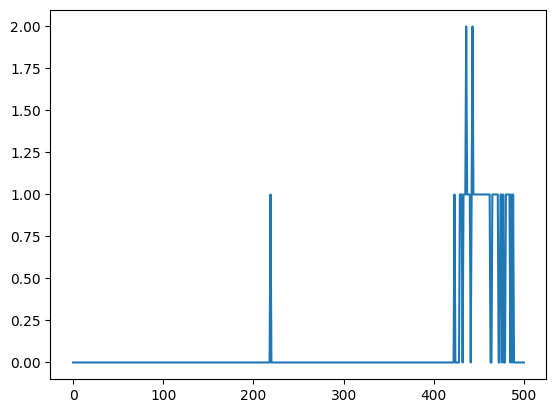

501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600


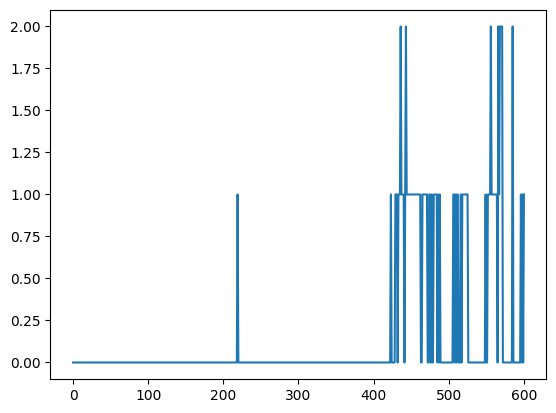

601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700


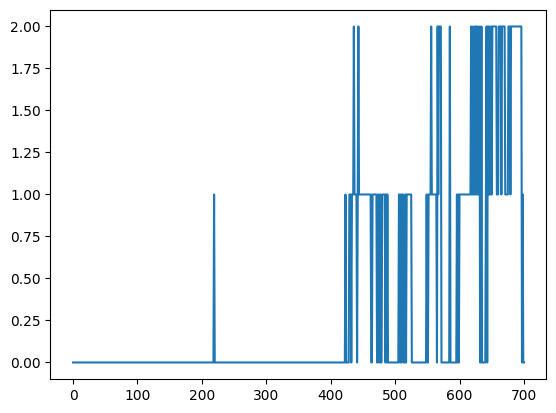

701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800


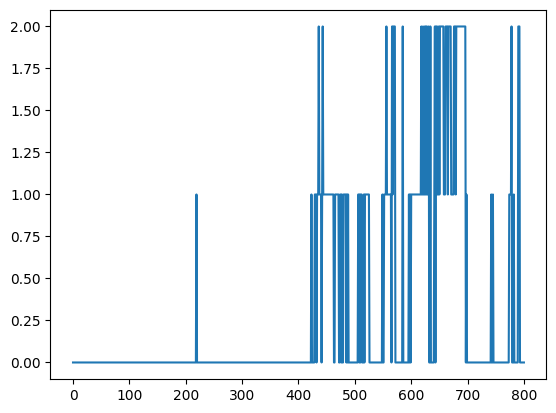

801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900


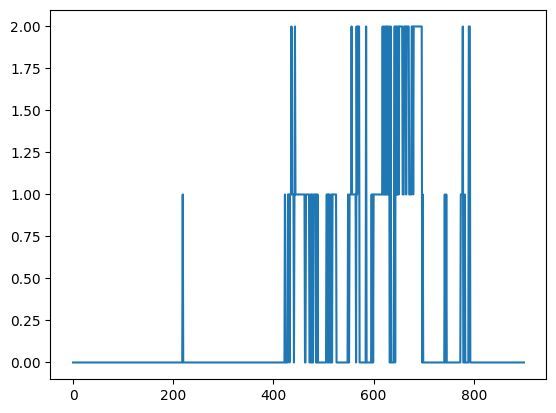

901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000


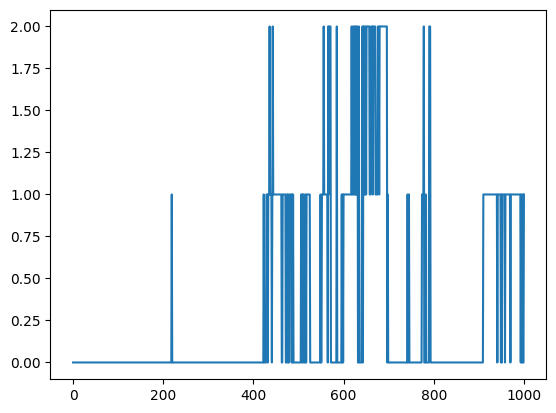

1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100


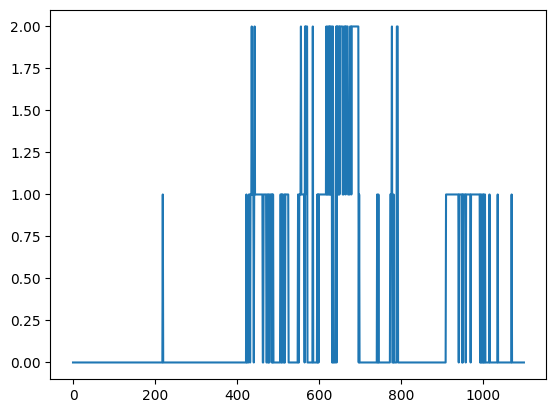

1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200


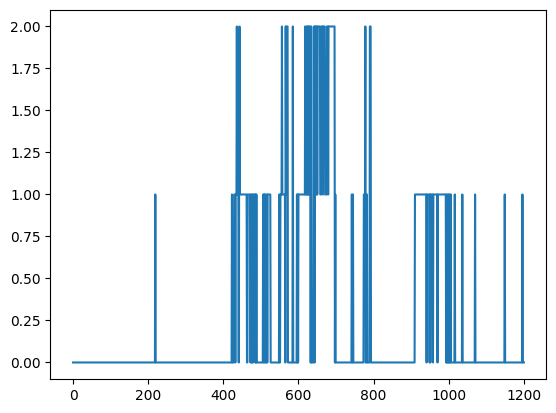

1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300


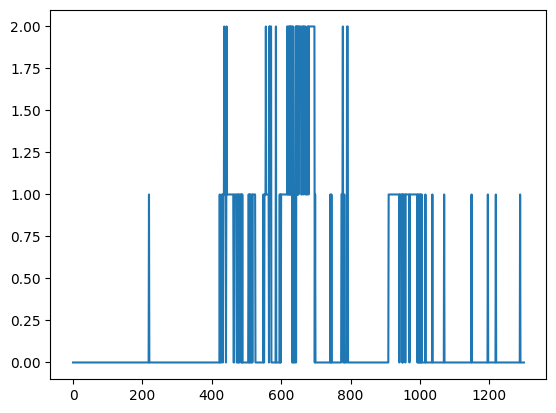

1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400


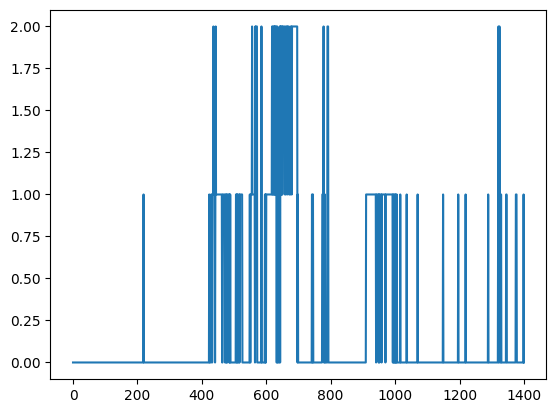

1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500


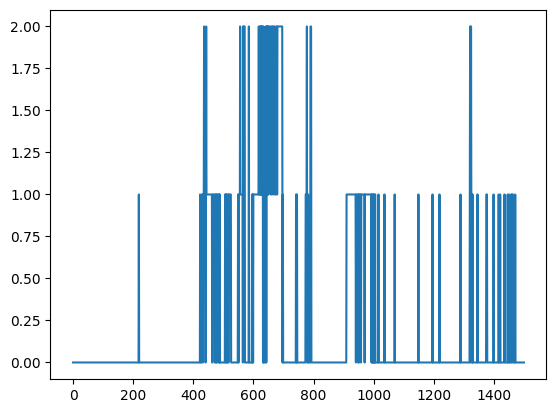

1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600


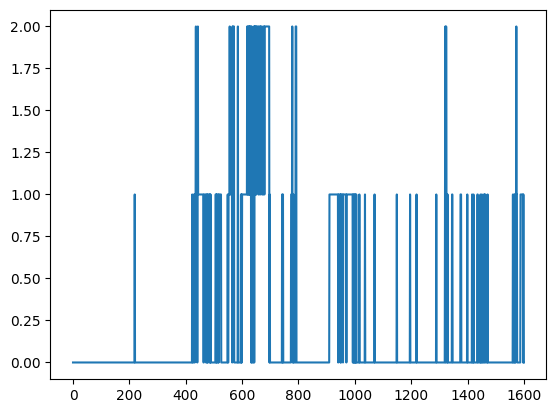

1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700


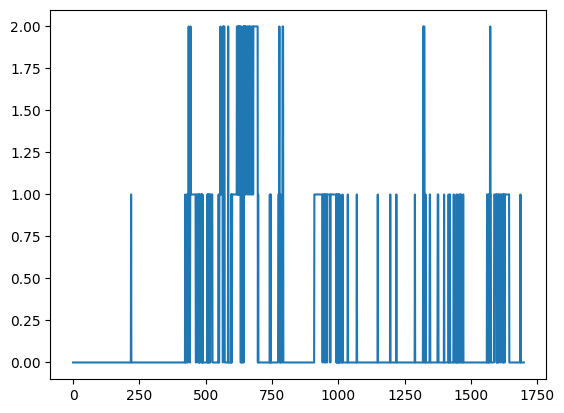

1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

SystemExit: 

In [26]:
import matplotlib.pyplot as plt
pg.init()
screen=pg.display.set_mode((1200,576))
pg.display.set_caption("Hello_nov")
clock=pg.time.Clock()
font = pg.font.Font('freesansbold.ttf', 22)
sky=pg.image.load('game_dev/finalbg.jpg').convert()
pipe=pg.image.load('game_dev/pipe.png').convert_alpha()
pipe=pg.transform.scale(pipe,(100,500))
pipet=pg.transform.rotate(pipe,180)
pipet=pg.transform.flip(pipet,True,False)
pipet_rect=pipet.get_rect(topleft=(1200,-50))
pipe_rect=pipe.get_rect(topleft=(1200,300))
pipe_rect_copy=pipe.get_rect(topleft=(550,300))
pipet_rect_copy=pipet.get_rect(topleft=(550,-50))
bird=pg.image.load('game_dev/bird.png').convert_alpha()
bird=pg.transform.scale(bird,(70,50))
bird_rect=bird.get_rect(center=(100,100))
sbt=font.render("START",True,"red")
sbt_rect=sbt.get_rect(center=(600,288))
screen.blit(sbt,sbt_rect)
l=[]

#defining timer for the obstacles to occur
for i in range(10000):
    bird_rect=bird.get_rect(center=(100,400))
    timer=pg.USEREVENT+1
    pg.time.set_timer(timer,1000)

    #bird=pg.transform.rotate(bird,-30)
    obs_list=[[500,400],[900,300],[1200,400]]
    obst_list=[[500,400-680],[900,300-680],[1200,400-680]]
    t=0
    smax=0
    a=0
    score="0"
    s=bird_rect.centery
    text = font.render(score, True, (77,208,225))
    text_rect = text.get_rect(center=(600,80))
    el=pg.draw.circle(screen,"blue",bird_rect.center,20)
    done=False
    cur_st=[0,0]
    cur_st[0]=(obs_list[0][0]-100)/4
    cur_st[1]=obs_list[0][1]-bird_rect.centery+301
    while not done:
        #draw everything and update
        for event in pg.event.get():
            if event.type==pg.QUIT:
                print(l)
                pg.quit()
                sys.exit()
            #if event.type==pg.KEYDOWN:
                #s=s+t*t-t*a
                #a=21
                #t=0.5
            if event.type==timer:
                x=4*random.randint(300,330)
                y=400+random.randint(-150,100)
                obs_list.append([x,y])
                obst_list.append([x,y-680])
        # defining thr rectangle postions
        el=pg.draw.circle(screen,"blue",bird_rect.center,20)
        
        #S
        
        screen.blit(sky,(-100,0))
        bird_rect.centery=s+t*t-t*a
        v=a-t*2
        screen.blit(bird,bird_rect)
        screen.blit(text,text_rect)

        obs_list,obst_list=obstacle_render(obs_list,obst_list)
        cur_st_en=create_tile_encoding(cur_st)
        #A
        if random.uniform(0,1)<eps:
            action=random.randint(0,1)
        else:
            action=np.argmax(Q_value[tuple(cur_st_en)])
        cur_st.append(action)
        cur_st_en.append(action)
        
        #S'
        next_state=get_next_state(cur_st,obs_list)
        next_state_en=create_tile_encoding(next_state)
        # in one time stamp x reduces by one and y by an amout specified by an equation of motion
        # so in order to find the subsequent states i would need to do a lookahead in the s using a hypothetical 
        # jump or no jump and then check the max of q values of both states and decide greedly....

        
        
        if cur_st[2]==0:
            ys=s+(t+0.5)*(t+0.5)-(t+0.5)*a
        else:
            ys=s+t*t-t*a + 0.5*0.5 -0.5*21
        el1=pg.draw.circle(screen,"blue",(104,ys),20)
        if  el1.colliderect(pipe.get_rect(topright=obs_list[0])) or el1.colliderect(pipet.get_rect(topright=obst_list[0])) or el1.bottom>=571 or el1.top<=5:
            reward=-400
            done=True
            Q_value[tuple(cur_st_en)]+=td_error*(reward)
        else:
            if random.uniform(0,1)<eps:
                action_next=random.randint(0,1)
            else:
                action_next=np.argmax(Q_value[tuple(next_state_en)])
            next_state.append(action_next)
            next_state_en.append(action_next)
            reward=0.5
            if next_state[0]==0:
                reward=5
            Q_value[tuple(cur_st_en)]+=td_error*(reward + Y*(Q_value[tuple(next_state_en)]-Q_value[tuple(cur_st_en)]))

        if action==1:
            s=s+t*t-t*a
            t=0
            a=21

        if obs_list and el.right==obs_list[0][0]+16:
            score=str(eval(score)+1)
            smax=max(0,eval(score))

            text = font.render(score, True,(77,208,225))
        #if (obs_list and obst_list and (el.colliderect(pipe.get_rect(topleft=obs_list[0])) or el.colliderect(pipet.get_rect(topleft=obst_list[0])))) or bird_rect.bottom>=576 or bird_rect.top<=0:
            #pg.quit()
            #sys.exit()
        t=t+0.5
        pg.display.update()
        clock.tick(120)
        cur_st=[next_state[0],next_state[1]]
    l.append(smax)
    print(i)
    if i%100==0:
        plt.plot(np.arange(i+1),l)
        plt.show()
    